In [7]:
import csv
from lazypredict.Supervised import LazyClassifier
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.preprocessing import LabelEncoder

In [8]:
# Load data
X = pd.read_csv('train_values.csv')[:28955]
Y = pd.read_csv('train_labels.csv')[:28955]
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Convert y_train and y_test to 1-dimensional arrays
y_train = y_train.values[:, 1]  # Select the first column
y_test = y_test.values[:, 1]    # Select the first column

In [9]:
models = ("RandomForestClassifier", "ExtraTreesClassifier", "ExtraTreeClassifier", "SVC")

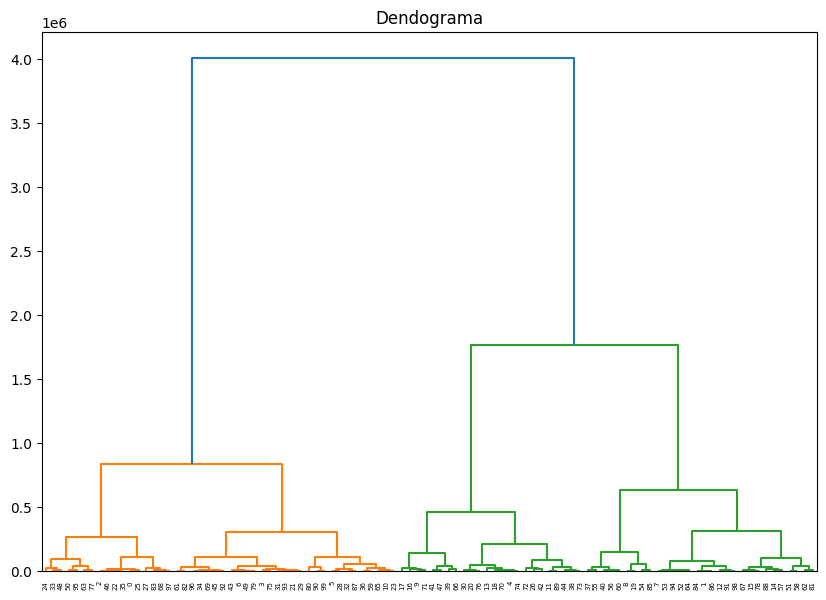

In [10]:
# Cargar datos
X = pd.read_csv('train_values.csv')
Y = pd.read_csv('train_labels.csv')
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Convertir columnas categóricas a numéricas
label_encoders = {}
for column in X_train.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    X_train[column] = le.fit_transform(X_train[column])
    X_test[column] = le.transform(X_test[column])
    label_encoders[column] = le

# Generar datos de ejemplo
data = X_train[:100]  # Usa una muestra de tus datos si son muchos

# Realizar el linkage
Z = linkage(data, method='ward')

# Crear el dendograma
plt.figure(figsize=(10, 7))
plt.title("Dendograma")
dendrogram(Z)
plt.show()

In [ ]:
clf = LazyClassifier(verbose=1, ignore_warnings=True, custom_metric=None)

#Vamos a usar una porción de los datasets para evitar problemas de memoria
models, predictions = clf.fit(X_train[:len(X_train)//2], X_test[:len(X_test)//2], y_train[:len(y_train)//2], y_test[:len(y_test)//2])
models

  0%|          | 0/32 [00:00<?, ?it/s]

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
